In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

df = pd.read_excel("DatasetTrainingMatif20250812.xlsx")
df = df.rename(columns={'Period': 'date'})
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.sort_index()
dup_count = df.index.duplicated(keep=False).sum()
print(f"Duplicate timestamps: {dup_count}")
df = df[~df.index.duplicated(keep='last')]
df = df.asfreq('B')
df = df.ffill()
df

Duplicate timestamps: 4


,Month,Supply_to_Demand_World_Less_China_CoarseGrains,Consumption_per_Capita_US_Wheat_+_CoarseGrains,Consumption_per_Capita_MEwUS_CornFeed,Consumption_To_Production_ME_CoarseGrains,Consumption_To_Production_MEwoEU_CoarseGrains,Supply_per_Capita_MEwoEU_Corn,Supply_to_Demand_MIwoChina_CoarseGrains,Stock_to_Use_MIwoChina_CoarseGrains,Stock_per_Capita_MIwoChina_CoarseGrains,...,Consumption_per_Capita_EU_WheatFeed,Consumption_per_Capita_China_WheatFeed,Oil_Average_Prices,GDP_deflator,Long_term_interest_rates,Short_term_interest_rates,US_Dollar_Index,Bonds_Price_Spread_10Y_3M,Bonds_Price_Spread_10Y_2Y,Matif_Prices
date,,,,,,,,,,,,,,,,,,,,,
1998-08-12,8.0,1.130764,623.419969,432.058645,0.677776,0.677776,374.363903,1.150727,0.168392,32.438725,...,113.860425,3.996512,12.71,100.000000,4.425238,3.50,101.79,0.387,0.085,116.01
1998-08-13,8.0,1.130764,623.419969,432.058645,0.677776,0.677776,374.363903,1.150727,0.168392,32.438725,...,113.860425,3.996512,13.21,100.000000,4.425238,3.50,101.55,0.396,0.062,118.15
1998-08-14,8.0,1.130764,623.419969,432.058645,0.677776,0.677776,374.363903,1.150727,0.168392,32.438725,...,113.860425,3.996512,13.35,100.000000,4.425238,3.50,102.35,0.378,0.073,118.15
1998-08-17,8.0,1.130764,623.419969,432.058645,0.677776,0.677776,374.363903,1.150727,0.168392,32.438725,...,113.860425,3.996512,13.20,100.000000,4.425238,3.50,102.13,0.410,0.068,118.61
1998-08-18,8.0,1.130764,623.419969,432.058645,0.677776,0.677776,374.363903,1.150727,0.168392,32.438725,...,113.860425,3.996512,12.92,100.000000,4.425238,3.50,102.35,0.349,0.072,118.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-06,8.0,1.076077,459.565455,293.514016,0.615644,0.615644,516.231018,1.092432,0.095258,18.367494,...,102.970202,23.278097,64.35,163.768123,2.630000,1.99,98.18,-0.100,0.530,193.75
2025-08-07,8.0,1.076077,459.565455,293.514016,0.615644,0.615644,516.231018,1.092432,0.095258,18.367494,...,102.970202,23.278097,63.88,163.768123,2.630000,1.99,98.40,-0.090,0.510,197.50
2025-08-08,8.0,1.076077,459.565455,293.514016,0.615644,0.615644,516.231018,1.092432,0.095258,18.367494,...,102.970202,23.278097,63.88,163.768123,2.630000,1.99,98.18,-0.050,0.510,196.50


In [2]:
# df = df[df.index > "2010-01-01"]

In [3]:
def make_horizon_target(price: pd.Series, horizon: int = 5, kind: str = "pct") -> pd.Series:
    """
    Compute horizon-h forward returns:
    r_{t,h} = log(P_{t+h}/P_t) or (P_{t+h}-P_t)/P_t
    """
    if kind == "log":
        r = np.log(price.shift(-horizon) / price)
    elif kind == "pct":
        r = (price.shift(-horizon) - price) / price
    else:
        raise ValueError("kind must be 'log' or 'pct'")
    return r.rename(f'ret_h{horizon}')

def make_supervised_df_horizon(df: pd.DataFrame,
                               price_col: str = 'Matif_Prices',
                               horizon: int = 5,
                               return_kind: str = 'pct') -> pd.DataFrame:
    out = pd.DataFrame(index=df.index)
    
    # --- target ---
    price = df[price_col]
    out[f'ret_h{horizon}'] = make_horizon_target(price, horizon=horizon, kind=return_kind)
    
    # --- lagged returns (short-term memory) ---
    if return_kind == "log":
        ret_1d = np.log(price / price.shift(1))
    elif return_kind == "pct":
        ret_1d = (price.shift(1) / price) / price
    ret_1d = np.log(price / price.shift(1))
    for L in [1, 2, 3, 5, 10, 20]:
        out[f'ret_lag_{L}'] = ret_1d.shift(L)
    
    # --- rolling stats of daily returns ---
    for W in [5, 10, 20, 60]:
        out[f'ret_rollmean_{W}'] = ret_1d.shift(1).rolling(W).mean()
        out[f'ret_rollstd_{W}']  = ret_1d.shift(1).rolling(W).std()
    
    # Price momentum (moving average gap)
    ma_fast = price.shift(1).rolling(10).mean()
    ma_slow = price.shift(1).rolling(30).mean()
    out['ma_gap_10_30'] = (ma_fast - ma_slow) / ma_slow
    
    # --- macro deltas/z-scores ---
    macro_cols = [c for c in df.columns if c not in {price_col}]
    for c in macro_cols:
        s = df[c]
        out[f'{c}_d1']  = s.diff(1).shift(1)
        out[f'{c}_d5']  = s.diff(5).shift(1)
    
    # --- calendar features ---
    out['dow'] = out.index.dayofweek
    out['month'] = out.index.month
    out['quarter'] = out.index.quarter
    out = pd.get_dummies(out, columns=['dow','month','quarter'], drop_first=True)

    return out.dropna()


In [4]:
horizon = 5 # try weekly returns (5 trading days)
supervised_h = make_supervised_df_horizon(df, 'Matif_Prices', horizon=horizon)

# Split
n_train = int(len(supervised_h)*0.8)
train, test = supervised_h.iloc[:n_train], supervised_h.iloc[n_train:]
X_train, y_train = train.drop(columns=[f'ret_h{horizon}']), train[f'ret_h{horizon}']
X_test, y_test   = test.drop(columns=[f'ret_h{horizon}']), test[f'ret_h{horizon}']

# Train
model = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.02,
    max_depth=4,
    subsample=0.7,
    colsample_bytree=0.6,
    reg_lambda=5,
    reg_alpha=1,
    random_state=42
)
model.fit(X_train, y_train)#, sample_weight=sample_weights)
# y_pred = pd.Series(model.predict(X_test), index=y_test.index)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [5]:
# import optuna
# from xgboost import XGBRegressor
# from sklearn.model_selection import TimeSeriesSplit
# import numpy as np

# tscv = TimeSeriesSplit(n_splits=5, gap=5, test_size=None)

# def objective(trial):
#     params = {
#         "objective": "reg:squarederror",
#         "tree_method": "hist",
#         "random_state": 42,
#         "n_estimators": trial.suggest_int("n_estimators", 600, 3000),
#         "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
#         "max_depth": trial.suggest_int("max_depth", 2, 10),
#         "min_child_weight": trial.suggest_float("min_child_weight", 0.5, 10.0, log=True),
#         "subsample": trial.suggest_float("subsample", 0.5, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
#         "gamma": trial.suggest_float("gamma", 1e-8, 10.0, log=True),
#         "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 10.0, log=True),
#         "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 50.0, log=True),
#     }

#     model = XGBRegressor(**params)

#     scores = []
#     for tr_idx, va_idx in tscv.split(X_train):
#         X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
#         y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

#         # Early stopping per fold
#         model.fit(
#             X_tr, y_tr,
#             eval_set=[(X_va, y_va)],
#             verbose=False
#         )
#         yhat = model.predict(X_va)

#         # Example metric: negative RMSE (maximize by returning -RMSE)
#         rmse = np.sqrt(((y_va - yhat) ** 2).mean())
#         scores.append(-rmse)

#         # Example alternative: Spearman for rank-quality
#         # scores.append(spearmanr(y_va, yhat).correlation)

#         # Example trading-aligned (requires your backtest function):
#         # scores.append(backtest_sharpe(y_va, yhat))  # implement to return Sharpe

#     return float(np.mean(scores))

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=60)  # increase if you can

# print("Best value:", study.best_value)
# print("Best params:", study.best_params)


In [6]:
# best_params = study.best_params
# # best_params.update(dict(objective="reg:squarederror", tree_method="hist", random_state=42))
# model = XGBRegressor(**best_params)
# # Retrain with early stopping on a recent validation slice
# val_frac = 0.1
# split = int(len(X_train) * (1 - val_frac))
# model.set_params(n_estimators=max(model.get_params()["n_estimators"], 2000))
# model.fit(
#     X_train.iloc[:split], y_train.iloc[:split],
#     eval_set=[(X_train.iloc[split:], y_train.iloc[split:])],
#     verbose=False
# )
# y_pred = pd.Series(model.predict(X_test), index=y_test.index)

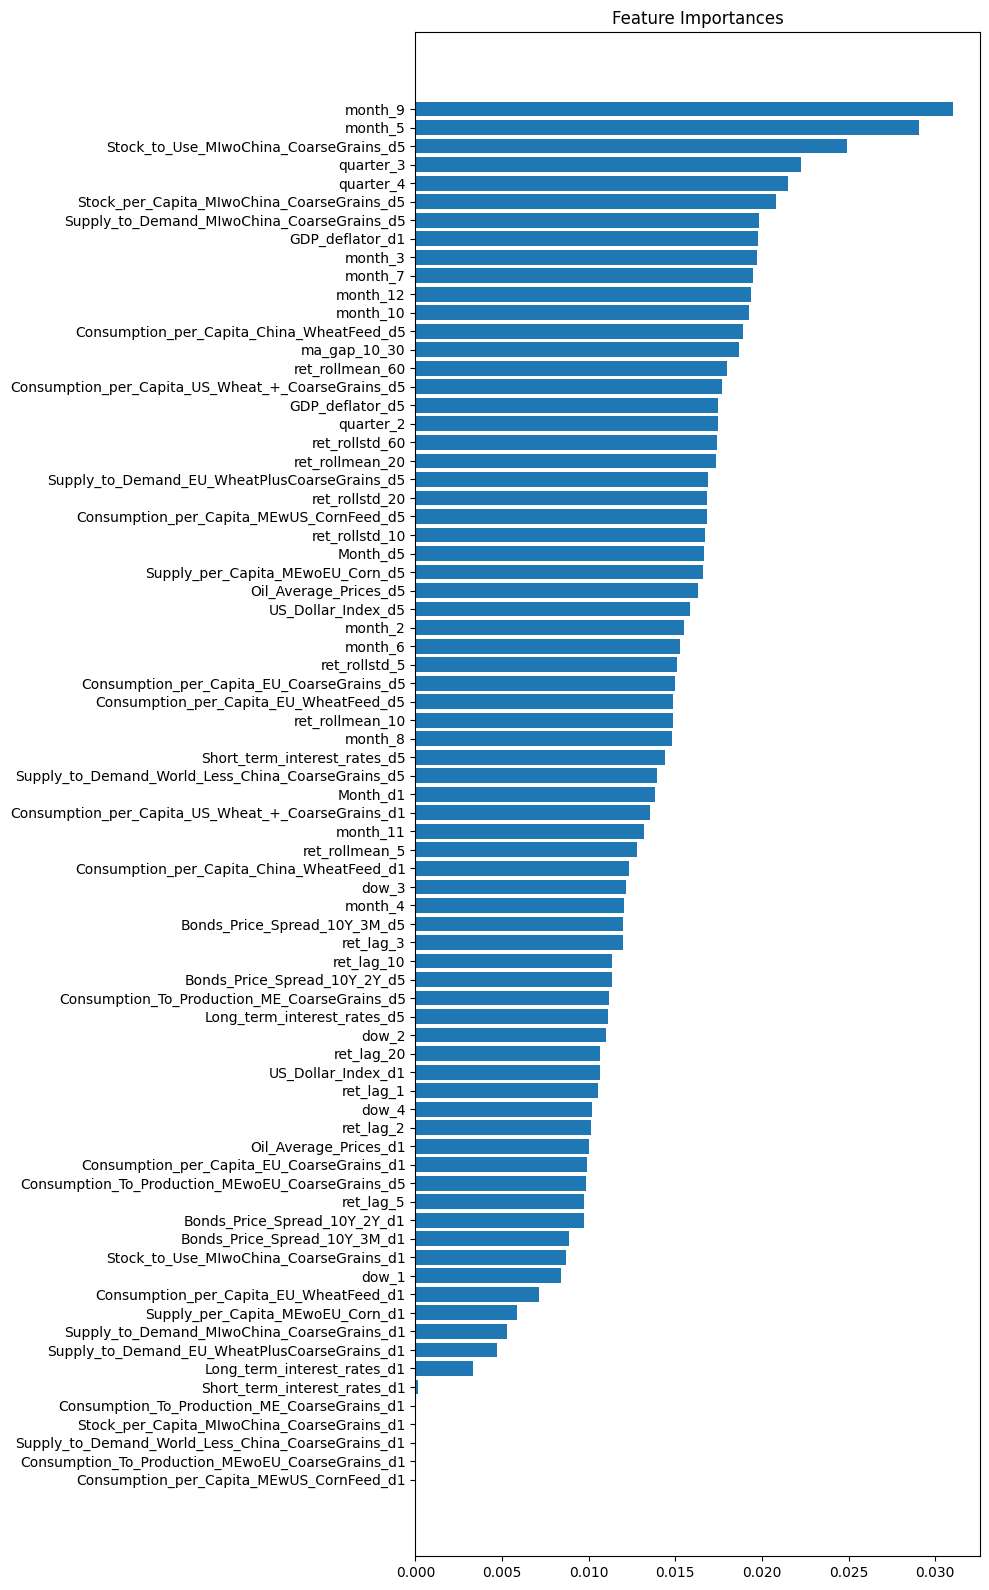

In [7]:
importances = model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)

plt.figure(figsize=(10, 16))
plt.title("Feature Importances")
plt.barh(range(len(importances)), importances[indices], align='center')
plt.yticks(range(len(importances)), features[indices])
plt.tight_layout()
plt.show()

In [8]:
import pandas as pd
from sklearn.base import clone

# 1) Get feature importance from the fitted model (by gain)
booster = model.get_booster()
imp = pd.Series(booster.get_score(importance_type="gain"), dtype=float)

# If XGBoost returned 'f0','f1',... map them back to your column names
if set(imp.index).issubset({f"f{i}" for i in range(X_train.shape[1])}):
    mapper = {f"f{i}": col for i, col in enumerate(X_train.columns)}
    imp.index = imp.index.map(mapper)

# 2) Align to your columns (missing → 0), then pick top 20
imp = imp.reindex(X_train.columns).fillna(0.0)
top20 = imp.sort_values(ascending=False).head(20).index.tolist()
print("Top 20 features:", top20)

# 3) Subset data
Xtr_top = X_train[top20]
Xte_top = X_test[top20]

# 4) Refit using the same hyperparameters
model_top = clone(model)   # copies params from the already-fit model
model_top.fit(Xtr_top, y_train)

# 5) Predict with the refit model
y_pred = pd.Series(model_top.predict(Xte_top), index=y_test.index)


Top 20 features: ['month_9', 'month_5', 'Stock_to_Use_MIwoChina_CoarseGrains_d5', 'quarter_3', 'quarter_4', 'Stock_per_Capita_MIwoChina_CoarseGrains_d5', 'Supply_to_Demand_MIwoChina_CoarseGrains_d5', 'GDP_deflator_d1', 'month_3', 'month_7', 'month_12', 'month_10', 'Consumption_per_Capita_China_WheatFeed_d5', 'ma_gap_10_30', 'ret_rollmean_60', 'Consumption_per_Capita_US_Wheat_+_CoarseGrains_d5', 'GDP_deflator_d5', 'quarter_2', 'ret_rollstd_60', 'ret_rollmean_20']


In [9]:
rmse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
corr = np.corrcoef(y_test, y_pred)[0,1]
hit_rate = (np.sign(y_test) == np.sign(y_pred)).mean()

print(f"Horizon: {horizon}-day")
print(f"RMSE: {rmse:.5f}, MAE: {mae:.5f}")
print(f"Correlation: {corr:.3f}")
print(f"Directional accuracy: {hit_rate:.2%}")


Horizon: 5-day
RMSE: 0.00192, MAE: 0.03039
Correlation: 0.034
Directional accuracy: 53.94%


In [10]:
def horizon_returns_to_prices(y_pred_ret, actual_prices, horizon=5):
    """
    Convert horizon-h return predictions into forecast prices.
    At time t, forecast = P_t * exp(rhat_{t,h})
    """
    forecast_prices = actual_prices.loc[y_pred_ret.index] * np.exp(y_pred_ret)
    return forecast_prices.rename(f'Price_hat_h{horizon}')

forecast_prices = horizon_returns_to_prices(y_pred, df['Matif_Prices'], horizon)


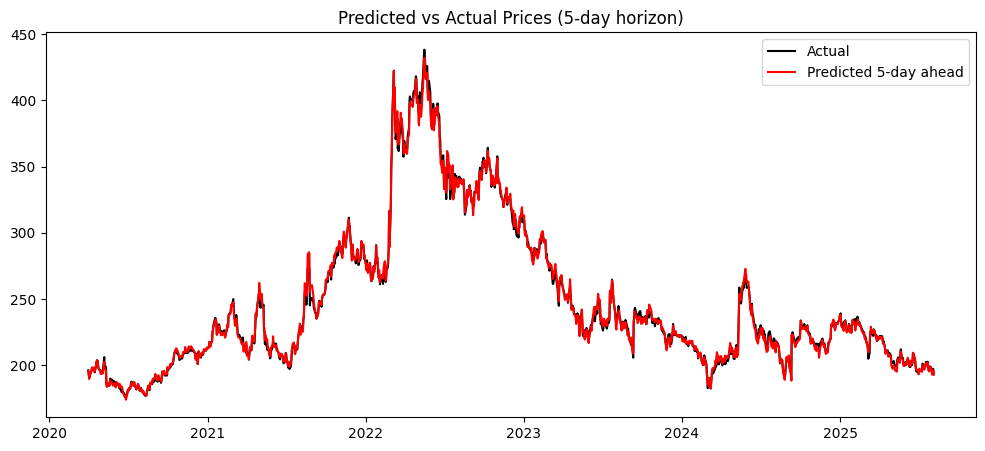

In [11]:
def plot_predicted_vs_actual(df, forecast_prices, horizon, start_date=None, end_date=None):
    idx = forecast_prices.index
    if start_date is not None:
        idx = idx[idx >= pd.to_datetime(start_date)]
    if end_date is not None:
        idx = idx[idx <= pd.to_datetime(end_date)]
    plt.figure(figsize=(12,5))
    plt.plot(idx, df.loc[idx, 'Matif_Prices'], label='Actual', color='black')
    plt.plot(idx, forecast_prices.loc[idx], label=f'Predicted {horizon}-day ahead', color='red')
    plt.title(f"Predicted vs Actual Prices ({horizon}-day horizon)")
    plt.legend()
    plt.show()

# Example usage:
plot_predicted_vs_actual(df, forecast_prices, horizon)#, start_date='2023-06-01', end_date='2025-01-01')


In [12]:
def backtest_horizon_strategy(y_pred_ret, prices, horizon=5, fee_bps=2.0, threshold=0.0):
    """
    Backtest for horizon-h predictions.
    - At time t: forecast horizon-h return (y_pred_ret[t])
    - Enter position, hold for h days, exit.
    - Positions do not overlap (step forward by h each time).
    - Costs applied on entry+exit.
    """

    trades = []
    dates = []
    equity = [1.0]  # start with 1 unit capital

    fee = fee_bps / 10000.0

    t = 0
    while t < len(y_pred_ret) - horizon:
        date = y_pred_ret.index[t]
        forecast = y_pred_ret.iloc[t]
        price_entry = prices.loc[date]
        price_exit  = prices.loc[y_pred_ret.index[t + horizon]]

        # realized return
        realized_ret = np.log(price_exit / price_entry)

        # direction
        if forecast > threshold:
            pnl = realized_ret - 2*fee    # long
        elif forecast < -threshold:
            pnl = -realized_ret - 2*fee   # short
        else:
            pnl = 0.0                     # flat

        trades.append(pnl)
        dates.append(y_pred_ret.index[t + horizon])

        # update equity
        equity.append(equity[-1] * np.exp(pnl))

        # step forward by horizon
        t += horizon

    # results
    equity = pd.Series(equity[1:], index=dates, name='Equity')
    trades = pd.Series(trades, index=dates, name='TradeRet')

    # metrics
    ann_factor = 252 / horizon  # because trades happen every h days
    avg = trades.mean()
    vol = trades.std()
    sharpe = (avg/vol)*np.sqrt(ann_factor) if vol>0 else np.nan
    cagr = equity.iloc[-1]**(ann_factor/len(trades)) - 1
    max_dd = (equity/equity.cummax() - 1).min()

    print(f"Horizon {horizon}-day strategy:")
    print(f"Trades: {len(trades)} | Hit rate: {( (trades>0).mean() ):.2%}")
    print(f"Avg return per trade: {avg:.4%}")
    print(f"Sharpe: {sharpe:.2f}")
    print(f"CAGR: {cagr:.2%} | MaxDD: {max_dd:.2%}")

    return pd.DataFrame({'Equity':equity,'TradeRet':trades})


In [13]:
# --- A) THRESHOLD FILTER ---
# Example: trade only when the 10-day forecast magnitude > 0.3% (log return)
thr = 0.003   # try 0.002, 0.003, 0.005
y_pred_thr = y_pred.copy()
y_pred_thr[np.abs(y_pred_thr) <= thr] = 0.0

# --- B) VOLATILITY FILTER ---
# Compute recent realized vol on price (use the same horizon window or 20d)
price = df['Matif_Prices']
daily_ret = np.log(price / price.shift(1))
vol_20 = daily_ret.rolling(20).std()

# Align vol to y_pred index
vol_20 = vol_20.reindex(y_pred.index).ffill()

# Example rule: skip top 10% volatility days
vol_cut = vol_20.quantile(0.90)
mask_calm = vol_20 < vol_cut

# Apply to the (thresholded) signal
y_pred_thr_vol = y_pred_thr.copy()
y_pred_thr_vol[~mask_calm] = 0.0

Horizon 5-day strategy:
Trades: 279 | Hit rate: 37.63%
Avg return per trade: 0.6268%
Sharpe: 1.26
CAGR: 37.15% | MaxDD: -30.59%


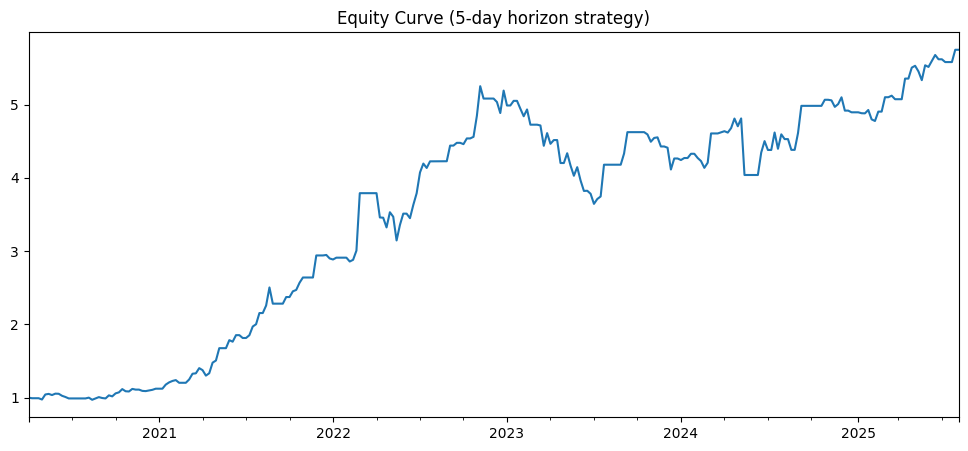

In [28]:
bt = backtest_horizon_strategy(
    # y_test,    # true horizon-h returns
    y_pred_thr_vol,    # predicted horizon-h returns
    df['Matif_Prices'],
    horizon=horizon,
    fee_bps=2.0,
    threshold=0.002
)

bt['Equity'].plot(figsize=(12,5), title=f'Equity Curve ({horizon}-day horizon strategy)')
plt.show()

In [15]:
def backtest_horizon_strategy_sized(
    y_true_ret: pd.Series,
    y_pred_ret: pd.Series,
    horizon: int = 10,
    fee_bps: float = 2.0,
    threshold: float = 0.0,
    vol_for_sizing: pd.Series | None = None,
    target_vol_pa: float = 0.15,   # target annualized vol (15%)
    cap: float = 2.0 # leverage
):
    """
    Non-overlapping horizon backtest with position sizing:
      size_t = min( cap , target_vol_daily / recent_vol_daily )
      where target_vol_daily = target_vol_pa / sqrt(252)
    Costs scale with |size_t|.
    """

    data = pd.concat(
        {"y_true": y_true_ret.rename("y_true"),
         "y_pred": y_pred_ret.rename("y_pred")},
        axis=1
    ).dropna()

    # Build a sizing series (daily vol). If not provided, use rolling 20d on returns.
    if vol_for_sizing is None:
        # proxy vol: realized vol of *daily* returns
        price = df['Matif_Prices']
        dret = np.log(price / price.shift(1))
        vol_for_sizing = dret.rolling(20).std()
    vol_for_sizing = vol_for_sizing.reindex(data.index).ffill()

    fee = fee_bps / 10000.0
    idx = data.index

    target_vol_daily = target_vol_pa / np.sqrt(252)

    trades, dates, equity = [], [], [1.0]

    t = 0
    n = len(data)
    while t <= n - 1:
        r_true = float(data.iloc[t]["y_true"])
        r_pred = float(data.iloc[t]["y_pred"])
        date   = idx[t]

        # Position sign after thresholding
        if r_pred > threshold:
            sign = 1.0
        elif r_pred < -threshold:
            sign = -1.0
        else:
            sign = 0.0

        # Size by vol (smaller size when recent vol is high)
        vol_t = float(vol_for_sizing.iloc[t]) if not np.isnan(vol_for_sizing.iloc[t]) else 0.0
        size = 0.0 if vol_t <= 0 else min(cap, target_vol_daily / vol_t)

        pnl = sign * size * r_true - 2 * fee * abs(sign * size)

        trades.append(pnl)
        dates.append(date)
        equity.append(equity[-1] * np.exp(pnl))

        t += horizon  # non-overlap

    trades = pd.Series(trades, index=dates, name="TradeRet")
    equity = pd.Series(equity[1:], index=dates, name="Equity")

    ann_factor = 252 / horizon
    avg, vol = trades.mean(), trades.std()
    sharpe = (avg / vol) * np.sqrt(ann_factor) if vol > 0 else np.nan
    cagr = equity.iloc[-1] ** (ann_factor / max(len(trades),1)) - 1
    max_dd = (equity / equity.cummax() - 1).min()

    print(f"[Sized] h={horizon} | Trades: {len(trades)} | Sharpe: {sharpe:.2f} | "
          f"CAGR: {cagr:.2%} | MaxDD: {max_dd:.2%}")

    return pd.DataFrame({"TradeRet": trades, "Equity": equity, "SizeVol": vol_for_sizing.reindex(dates)})

In [16]:
from arch import arch_model
import numpy as np
import pandas as pd

# 1) Build daily log returns from your price
price = df['Matif_Prices'].sort_index()
ret_d = np.log(price / price.shift(1)).dropna()

# 2) Choose the train/test split boundary you already used
# If you have X_train / X_test from the model pipeline, reuse its split:
train_end_date = X_train.index[-1]  # last date of training
# Alternatively: train_end_date = ret_d.index[int(len(ret_d)*0.8)]

# 3) Fit GARCH(1,1) with Student-t on the TRAIN PART ONLY (no parameter look-ahead)
# arch models are numerically stabler if you fit on percent returns
train_ret_pct = (ret_d.loc[:train_end_date] * 100.0)

am = arch_model(train_ret_pct, mean='Zero', vol='GARCH', p=1, q=1, dist='t')
res = am.fit(disp='off')

# 4) Generate one-step-ahead conditional variance forecasts for the WHOLE index
# Use last_obs so parameters are estimated only up to train_end_date
am_full = arch_model((ret_d * 100.0), mean='Zero', vol='GARCH', p=1, q=1, dist='t')
res_full = am_full.fit(last_obs=train_end_date, update_freq=0, disp='off')

# Forecast horizon=1, reindex to full dates
fcast = res_full.forecast(horizon=horizon, reindex=True)

# 5) Daily sigma_t (std dev); convert back from percent to decimal
vol_garch_daily = np.sqrt(fcast.variance.iloc[:, 0]) / 100.0
vol_garch_daily.name = 'vol_garch_daily'

vol_for_sizing = vol_garch_daily.reindex(y_pred.index).ffill()


[Sized] h=5 | Trades: 280 | Sharpe: 1.27 | CAGR: 48.12% | MaxDD: -34.26%


<Axes: title={'center': 'Equity Curve (sized, filters applied)'}>

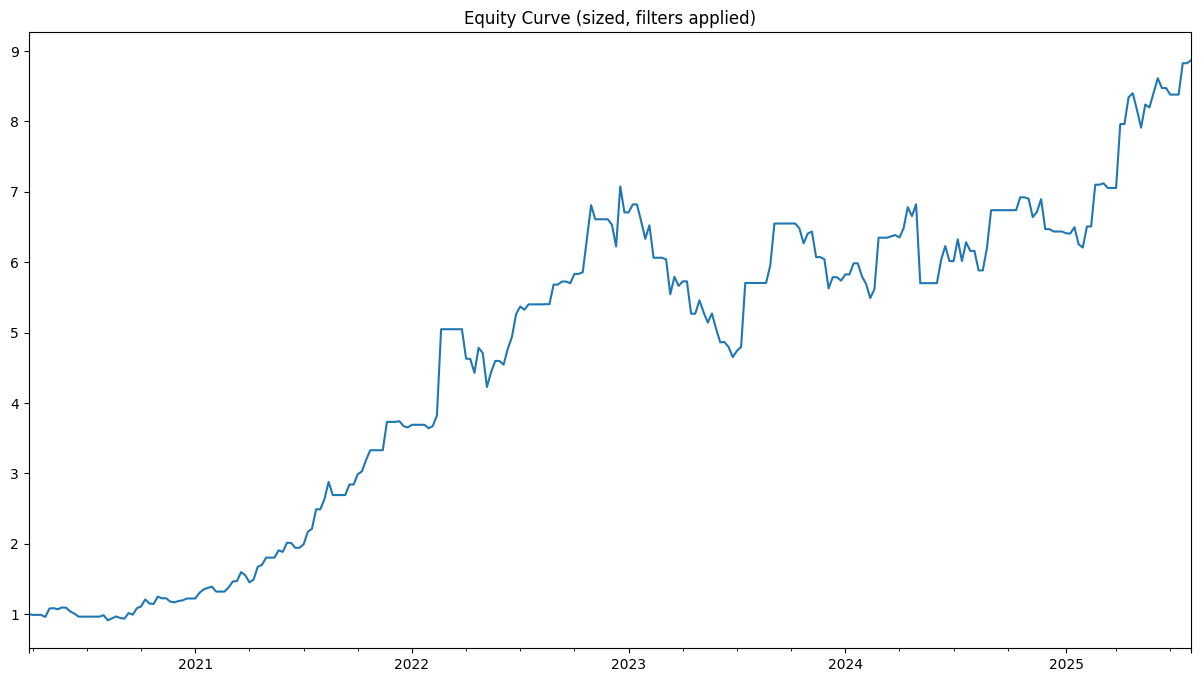

In [17]:
bt_sized = backtest_horizon_strategy_sized(
    y_test,                 # true h-day returns
    y_pred_thr_vol,         # filtered predictions
    horizon=horizon,
    vol_for_sizing=vol_for_sizing,
    fee_bps=2.0,
    threshold=0.002,          # or reuse thr
    target_vol_pa=0.3,
    cap= 3.0
)
bt_sized['Equity'].plot(figsize=(15,8), title='Equity Curve (sized, filters applied)')

In [18]:
def subperiod_stats(equity: pd.Series, splits: list[pd.Timestamp]):
    """
    Print CAGR & MaxDD for consecutive subperiods delimited by `splits`.
    Example splits = [pd.Timestamp('2021-01-01'), pd.Timestamp('2023-01-01')]
    """
    dates = [equity.index.min()] + splits + [equity.index.max()]
    for i in range(len(dates)-1):
        seg = equity.loc[(equity.index>dates[i]) & (equity.index<=dates[i+1])]
        if len(seg) < 5: 
            continue
        ann_factor = 252 / horizon
        cagr = seg.iloc[-1] ** (ann_factor/len(seg)) - 1
        mdd = (seg/seg.cummax() - 1).min()
        print(f"{dates[i].date()} → {dates[i+1].date()} | CAGR {cagr:.2%} | MaxDD {mdd:.2%}")
splits = [pd.Timestamp('2022-01-01'), pd.Timestamp('2023-01-01')]
subperiod_stats(bt_sized['Equity'], splits)

2020-03-31 → 2022-01-01 | CAGR 104.93% | MaxDD -16.61%
2022-01-01 → 2023-01-01 | CAGR 532.69% | MaxDD -16.27%
2023-01-01 → 2025-08-05 | CAGR 124.53% | MaxDD -31.80%


Horizon 5-day strategy:
Trades: 227 | Hit rate: 37.89%
Avg return per trade: 0.5653%
Sharpe: 1.24
CAGR: 32.97% | MaxDD: -27.84%


<Axes: title={'center': 'Equity (2022 excluded)'}>

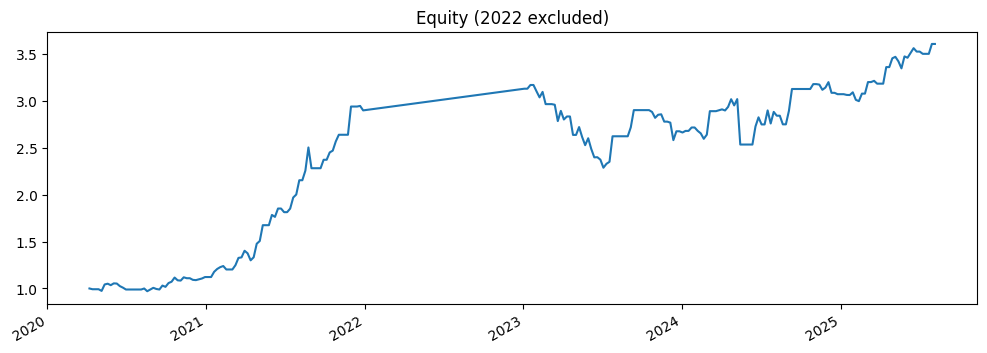

In [19]:
# Example: drop 2022 from evaluation
mask_ex_2022 = ~( (y_test.index >= '2022-01-01') & (y_test.index < '2023-01-01') )
y_test_ex = y_test[mask_ex_2022]
y_pred_ex = y_pred_thr_vol.reindex(y_test_ex.index)

bt_ex = backtest_horizon_strategy(y_pred_ex, df['Matif_Prices'], horizon=horizon, fee_bps=2.0, threshold=0.0)
bt_ex['Equity'].plot(figsize=(12,4), title='Equity (2022 excluded)')


Horizon 5-day strategy:
Trades: 279 | Hit rate: 51.97%
Avg return per trade: 0.1945%
Sharpe: 0.32
CAGR: 10.30% | MaxDD: -37.33%


<Axes: title={'center': 'Equity (Momentum)'}>

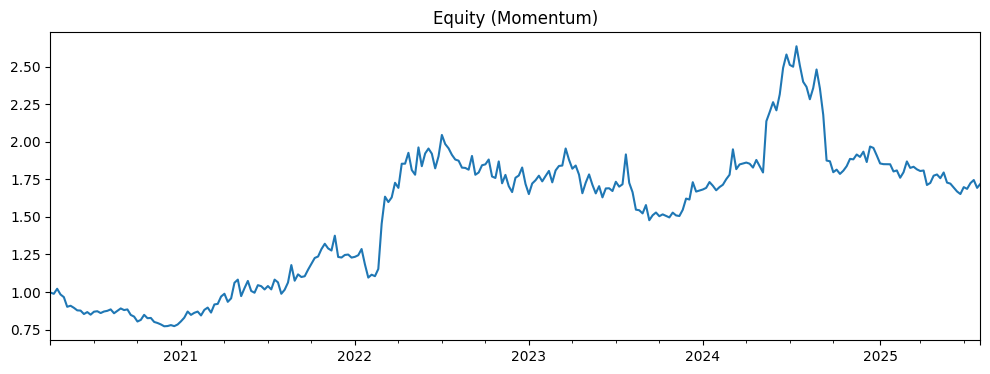

In [20]:
# Naïve momentum baseline: sign of last 10-day return
last_h_ret = np.log(df['Matif_Prices'] / df['Matif_Prices'].shift(horizon)).reindex(y_test.index)
baseline_mom = last_h_ret  # use itself as "prediction"
bt_mom = backtest_horizon_strategy(baseline_mom, df['Matif_Prices'], horizon=horizon, fee_bps=2.0, threshold=0.0)
bt_mom['Equity'].plot(figsize=(12,4), title='Equity (Momentum)')

Horizon 5-day strategy:
Trades: 279 | Hit rate: 47.67%
Avg return per trade: -0.0451%
Sharpe: -0.08
CAGR: -2.25% | MaxDD: -59.67%


<Axes: title={'center': 'Equity (Always Positive)'}>

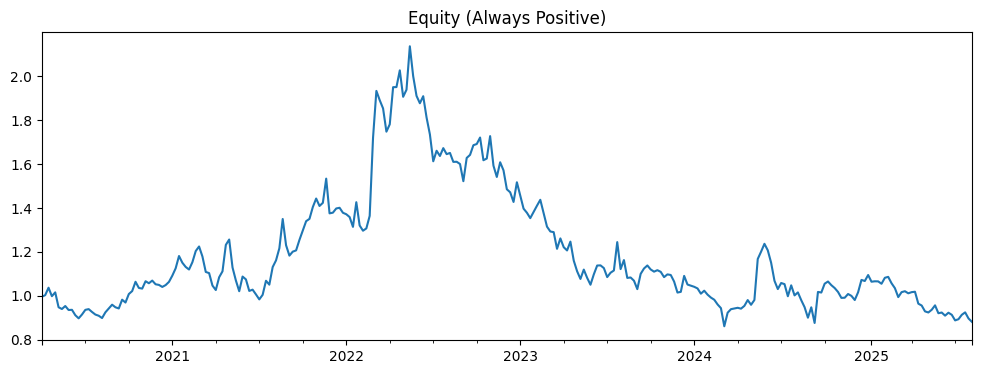

In [21]:
# Always-long baseline: predict small positive return every time
baseline_long = pd.Series(0.001, index=y_test.index)  # ~0.1% as a dummy positive signal
bt_long = backtest_horizon_strategy(baseline_long, df['Matif_Prices'], horizon=horizon, fee_bps=2.0, threshold=0.0)
bt_long['Equity'].plot(figsize=(12,4), title='Equity (Always Positive)')